In [1]:
# Mount google drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Imports.
import cv2
from cv2 import (VideoCapture as VC, CAP_PROP_FRAME_COUNT as n_frames, 
                 VideoWriter as CW, CAP_PROP_FPS as n_fps)
from cv2.dnn import readNetFromDarknet as DarkNet
from cv2.dnn import blobFromImage, NMSBoxes
import math as mt
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd
import os

Mounted at /content/drive


In [10]:
# Change directory.
os.chdir('/content/drive/My Drive/MA305_Project/transfer_video')

# Inputs.
input_video = 'videos/IMG_4373.MOV'
output_video = 'output/highway.MOV'
weights_file = 'coco.weights'
cfg_file = 'coco.cfg'

In [11]:
# Load the labels from COCO.
with open('coco.csv', 'r') as lines:
  coco_labels = lines.readlines()[0].split(',')
print(coco_labels)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush\n']


In [12]:
# Function
def image_process(frame, network, labels, colors, size = 416):
    
    # Extract the original dimensions of the image.
    H, W = frame.shape[0], frame.shape[1]
    
    # Normalize the image, and reshape it to the given size.
    network.setInput(blobFromImage(frame, 1/255, (size, size), swapRB=True))
    
    # Identify the last layers of the Network. The DarkNet network has
    # three output layers: YOLO 82, YOLO 94, and YOLO 106. Flow the image
    # through the CNN and save the three outputs to a layer called last_layers.
    last_layers = []
    for i in network.forward(['yolo_82', 'yolo_94', 'yolo_106']):
        last_layers.append(i)
    output = np.array(list(itertools.chain.from_iterable(last_layers)))
    
    # Save the output to a pandas dataframe.
    full_output = pd.DataFrame(data=output)
    
    # Obtain the scores of the CNN, which are the 5th through 85th columns.
    # Convert the results to a data_frame, and filter to obtain only the 
    # objects that have a high confidence, above 60%.
    scores = output[:, 5:]
    df = pd.DataFrame(data=scores)
    filtered_df = df > 0.6
    filtered_output = full_output[filtered_df.isin([True]).any(axis=1)]
    
    ############################################################
    
    # The following section of the code was based on a previous 
    # implementation by Adrian Rosebrock. The original code can be found 
    # in the following directory:
    # https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/
    
    # Identify the boxes, their probabilities, and the identified classes.
    boxes, probabilities, classes = [], [], []
    for _, row in filtered_output.iterrows():
        row = np.array(row)
        scores = row[5:]
        idx = np.argmax(scores)
        cx, cy, w, h = row[0:4] * np.array([W, H, W, H])
        boxes.append([cx - (w / 2), cy - (h / 2), w, h])
        probabilities.append(float(scores[idx]))
        classes.append(idx)

	  # Apply non-maxima suppression. CV2 returns the best bounding boxes.
    idxs = NMSBoxes(boxes, probabilities, 0.5, 0.3).flatten()
    bounding_boxes = np.array(boxes)[[idxs], :4][0]

    # The labs array contains the indices of the labels that were detected.
    # This array is returned by the function, along with the updated image.
    labs = []
    
    # Draw rectangles and add text (extracted and slightly modified from 
    # Rosebrock's code).
    if len(bounding_boxes) > 0:
        
        # Process each of the boundig boxes returned by the non-maxima
        # supression step.
        for i, box in zip(idxs, bounding_boxes):
            
            # Draw a bounding box rectangle.
            x, y, w, h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
            color = [int(c) for c in colors[classes[i]]]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            
            # Identify the label (to print on the image). Save the index of the
            # label to the labs array. 
            idx = classes[i]
            labs.append(idx)
            label = labels[idx]

            # Write the class and probability on top of the image.
            text = "{}: {:.2f}".format(label, probabilities[i])
            cv2.putText(frame, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
    ############################################################
    
	  # Frame
    return frame, labs

Original:


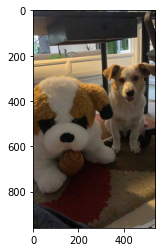

Processed:


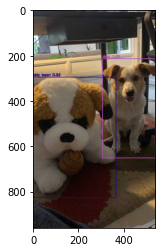

Original:


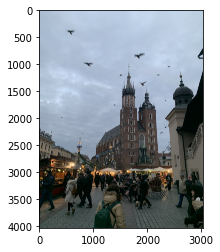

Processed:


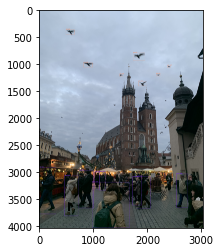

Original:


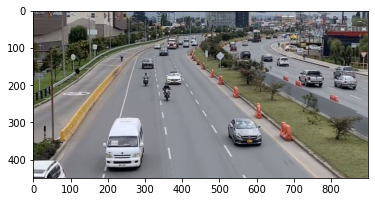

Processed:


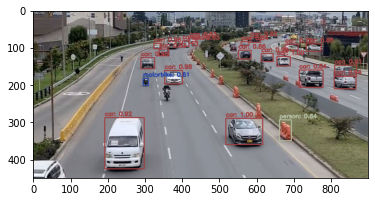

In [16]:
# Import the DarkNet model, and load the pre-trained weights.
net = DarkNet(cfg_file, weights_file)

def cnn_image(directory):
  frame = cv2.imread(directory)
  print('Original:')
  plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  plt.show()
  processed_frame, idxs = image_process(frame, net, coco_labels, np.random.randint(0, 255, size=(len(coco_labels), 3)))
  print('Processed:')
  plt.imshow(cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB))
  plt.show()

# Process individual images.
cnn_image('dog.jpg')
cnn_image('krakow.jpg')
cnn_image('highway.JPG')

In [14]:
# Use OpenCV to load the video and obtain the number of frames.
video = VC(input_video)
number_of_frames = int(video.get(n_frames))
fps = video.get(n_fps)

Frame count:  0 , Progress:  0.0 %


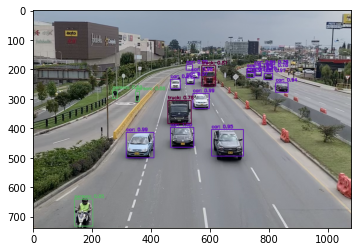

Saving frame:  0
Frame count:  29 , Progress:  1.6 %


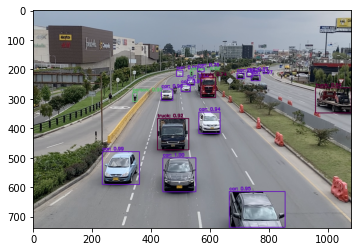

Saving frame:  29
Frame count:  58 , Progress:  3.2 %


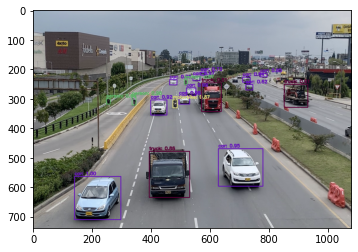

Saving frame:  58
Frame count:  87 , Progress:  4.8 %


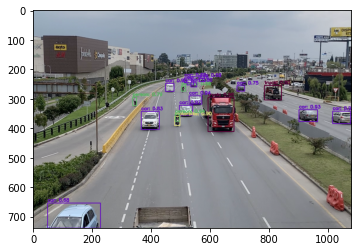

Saving frame:  87
Frame count:  116 , Progress:  6.41 %


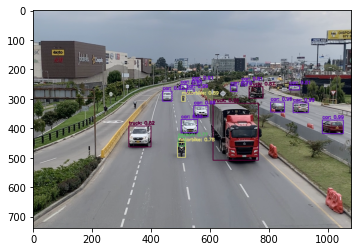

Saving frame:  116
Frame count:  145 , Progress:  8.01 %


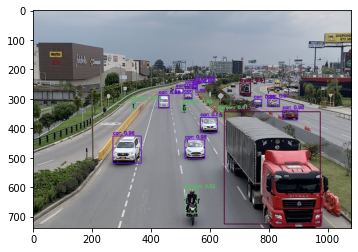

Saving frame:  145
Frame count:  174 , Progress:  9.61 %


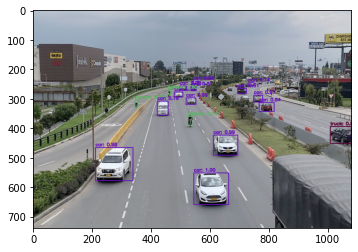

Saving frame:  174
Frame count:  203 , Progress:  11.21 %


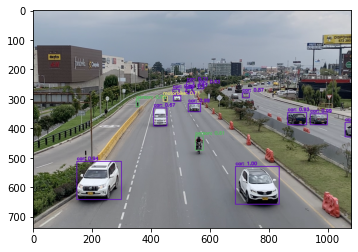

Saving frame:  203
Frame count:  232 , Progress:  12.81 %


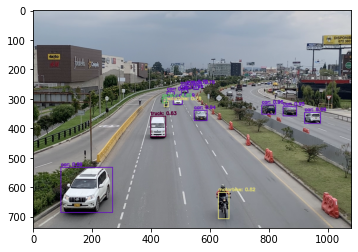

Saving frame:  232
Frame count:  261 , Progress:  14.41 %


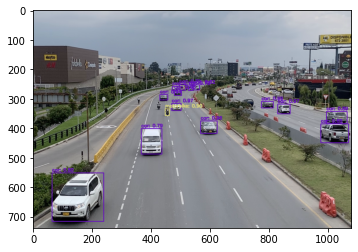

Saving frame:  261
Frame count:  290 , Progress:  16.01 %


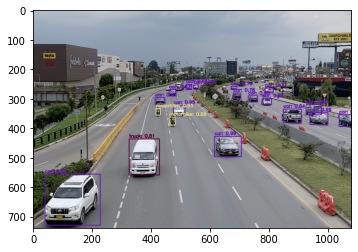

Saving frame:  290
Frame count:  319 , Progress:  17.61 %


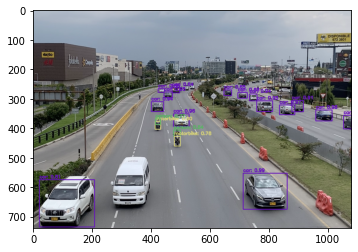

Saving frame:  319
Frame count:  348 , Progress:  19.22 %


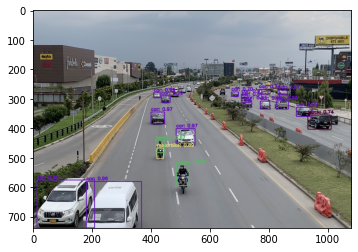

Saving frame:  348
Frame count:  377 , Progress:  20.82 %


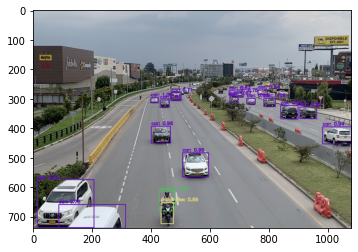

Saving frame:  377
Frame count:  406 , Progress:  22.42 %


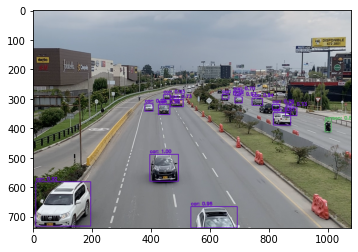

Saving frame:  406
Frame count:  435 , Progress:  24.02 %


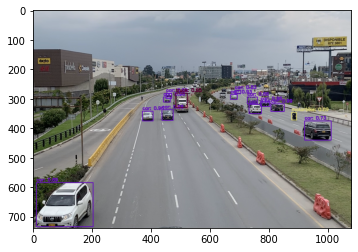

Saving frame:  435
Frame count:  464 , Progress:  25.62 %


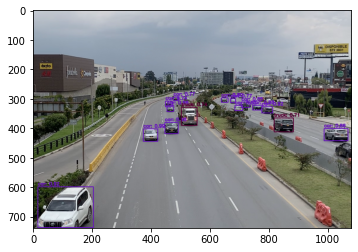

Saving frame:  464
Frame count:  493 , Progress:  27.22 %


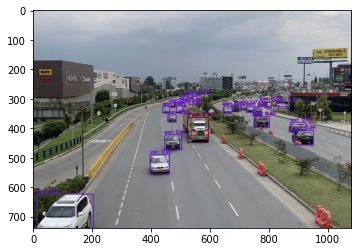

Saving frame:  493
Frame count:  522 , Progress:  28.82 %


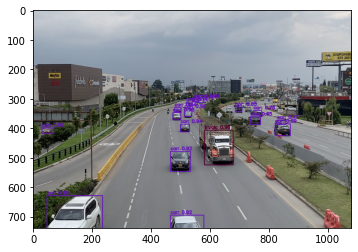

Saving frame:  522
Frame count:  551 , Progress:  30.43 %


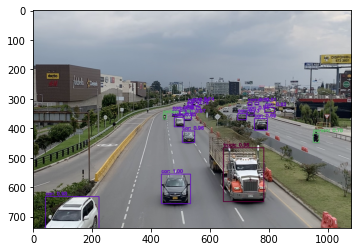

Saving frame:  551
Frame count:  580 , Progress:  32.03 %


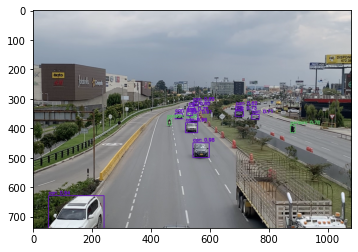

Saving frame:  580
Frame count:  609 , Progress:  33.63 %


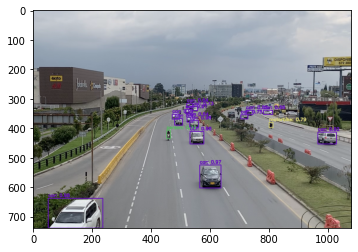

Saving frame:  609
Frame count:  638 , Progress:  35.23 %


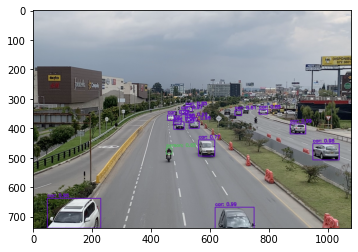

Saving frame:  638
Frame count:  667 , Progress:  36.83 %


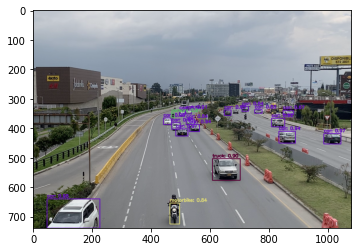

Saving frame:  667
Frame count:  696 , Progress:  38.43 %


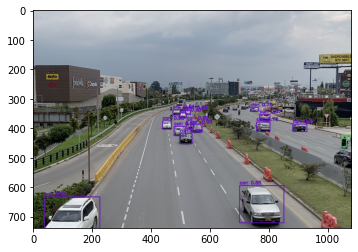

Saving frame:  696
Frame count:  725 , Progress:  40.03 %


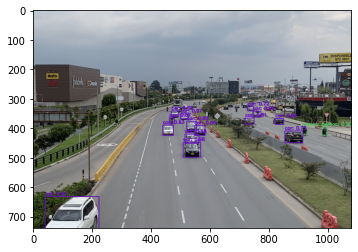

Saving frame:  725
Frame count:  754 , Progress:  41.63 %


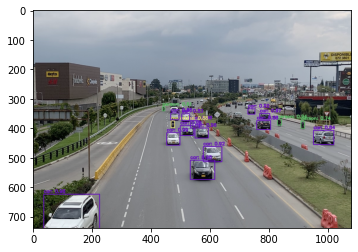

Saving frame:  754
Frame count:  783 , Progress:  43.24 %


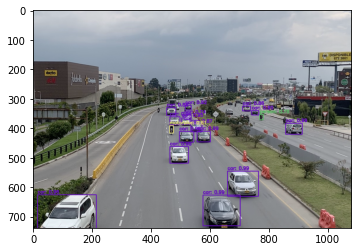

Saving frame:  783
Frame count:  812 , Progress:  44.84 %


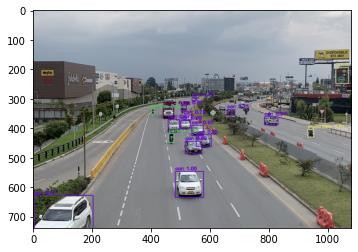

Saving frame:  812
Frame count:  841 , Progress:  46.44 %


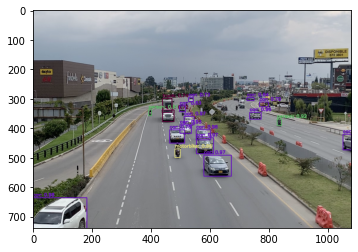

Saving frame:  841
Frame count:  870 , Progress:  48.04 %


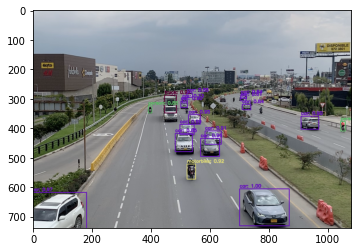

Saving frame:  870
Frame count:  899 , Progress:  49.64 %


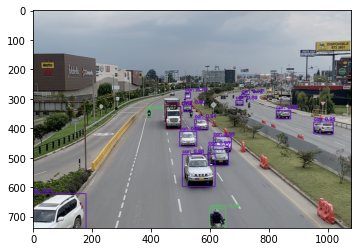

Saving frame:  899
Frame count:  928 , Progress:  51.24 %


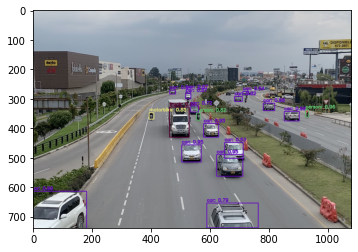

Saving frame:  928
Frame count:  957 , Progress:  52.84 %


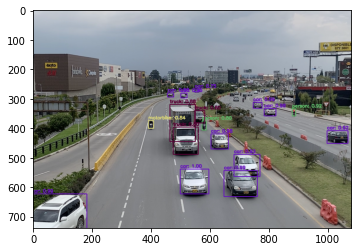

Saving frame:  957
Frame count:  986 , Progress:  54.45 %


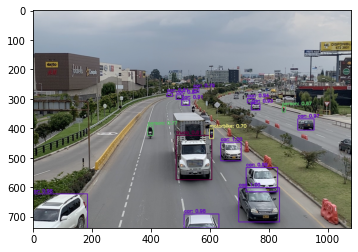

Saving frame:  986
Frame count:  1015 , Progress:  56.05 %
Frame count:  1044 , Progress:  57.65 %
Frame count:  1073 , Progress:  59.25 %
Frame count:  1102 , Progress:  60.85 %
Frame count:  1131 , Progress:  62.45 %
Frame count:  1160 , Progress:  64.05 %
Frame count:  1189 , Progress:  65.65 %
Frame count:  1218 , Progress:  67.26 %
Frame count:  1247 , Progress:  68.86 %
Frame count:  1276 , Progress:  70.46 %
Frame count:  1305 , Progress:  72.06 %
Frame count:  1334 , Progress:  73.66 %
Frame count:  1363 , Progress:  75.26 %
Frame count:  1392 , Progress:  76.86 %
Frame count:  1421 , Progress:  78.46 %
Frame count:  1450 , Progress:  80.07 %
Frame count:  1479 , Progress:  81.67 %
Frame count:  1508 , Progress:  83.27 %
Frame count:  1537 , Progress:  84.87 %
Frame count:  1566 , Progress:  86.47 %
Frame count:  1595 , Progress:  88.07 %
Frame count:  1624 , Progress:  89.67 %
Frame count:  1653 , Progress:  91.28 %
Frame count:  1682 , Progress:  92.88 %
Frame count:  1711 , 

In [15]:
# Create a new video.
_, first_frame = video.read()
video_shape = first_frame.shape
new_video = CW(output_video, 1196444237, mt.floor(fps), 
              (video_shape[1], video_shape[0]), isColor = True)


classes = []
count = 0
n = int(fps)
save_frames = True
np.random.seed(42)
colors =  np.random.randint(0, 255, size=(len(coco_labels), 3))
while video.isOpened():

    # Print the current frame number, and progress. 
    progress = round(count*100/number_of_frames, 2)
    print('Frame count: ', count, ', Progress: ', progress, '%')
    if progress >= 100:
      break

    # Read the next frame.
    _, frame = video.read()

    # Process the current frame using the image_process function.
    # This returns a frame with the identified objects and their 
    # respective rectangles. It also returns the indexes of the classes
    # that have been identified in the image.
    frame = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE) 
    frame, idxs = image_process(frame, net, coco_labels, colors)
    classes.append(idxs)

    # Save frame to the new video.
    new_video.write(frame)

    # Save frames (only if more than 5 objects were identified).
    if save_frames and len(idxs) > 5 and count < 1000:
      plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
      plt.show()
      print('Saving frame: ', count)
      cv2.imwrite('output/frames/frame{:d}.jpg'.format(count), frame)

    # Set the count of the next frma to be processed.
    count += n
    video.set(1, count)
